# Vaje 7: Nevronske mreže 1

## Naloga 1: Usmerjene (feedforward) nevronske mreže 

Z ukazom `pip3 install torch torchvision` si inštaliraj paket [PyTorch](https://pytorch.org/get-started/locally/), ki ga bomo uporabljali za nevronske mreže in ukazom `pip3 install tqdm` paket [tqdm](https://github.com/tqdm/tqdm), ki ga bomo uporabljali za izpisovanje sprotnih rezultatov


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transform
from torchvision.datasets import MNIST
from tqdm import tqdm

Naložimo podatkovno množico. Uporabljali bomo slike števk, za katere bomo poskusili napovedati, katera števka je na sliki.

In [7]:
batch_size = 32

train_set = MNIST('../Podatki/', train=True, download=True, 
                  transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

test_set = MNIST('../Podatki/', train=False, download=True, 
                 transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

Poglejmo si, kako naši podatki zgledajo

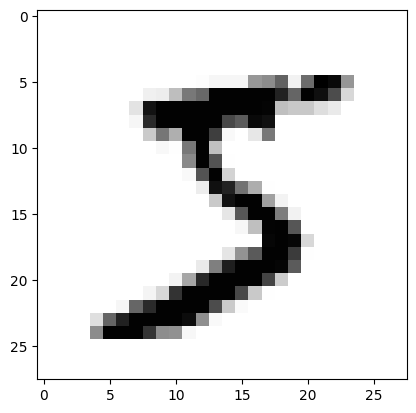

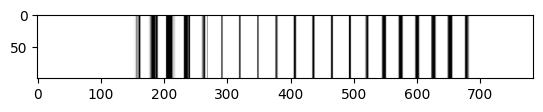

Label 5


In [3]:
# Prvi učni primer pretvorimo v numpy array in ga izrišemo
first_image = train_set[0][0].numpy()[0, :, :]
plt.imshow(first_image, cmap="Greys")
plt.show()

# Vhodni podatki v usmerjeno nevronsko mrežo bodo vektorji. Zato sliko pretvorimo v vektor (lepimo vrstice eno za drugo). Za lepše viden izris ta vektor 100-krat skopiramo 
plt.imshow(np.repeat(first_image.reshape((28*28, 1)).T, repeats=100, axis=0), cmap="Greys")
plt.show()

# Izpišemo ciljno vrednost prvega učnega podatka
print(f"Label {train_set[0][1]}")

Sestavimo napovedni model, ga natrenirajmo in potestiramo

In [4]:
# Definirajmo našo nevronsko mrežo
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Definiramo objekt, ki bo sliko spremenil v vektor
        self.flatten = nn.Flatten()
        # Definiramo sloje naše nevronske mreže
        self.linear_relu_stack = nn.Sequential(
            # Polno povezan sloj z vhodno dimenzijo 28*28 in izhodno dimenzijo 64
            nn.Linear(28*28, 64),
            # Aktivacijska funkcija ReLu
            nn.ReLU(),
            nn.Linear(64, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        # Definiramo še objekt, ki bo izhod pretvoril v "verjetnosti" (pozitivne vrednosti, ki se šeštejejo v 1)
        # parameter dim=1 nam to naredi po drugi (1-ti) dimenziji. Vsak podatek po prvi (0-ti) dimenziji je ena slika v skupini (batchu)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        # Vhodno sliko pretvorimo v vektor
        x = self.flatten(x)
        # Vektor pošljemo čez vse sloje in aktivacijske vrednosti
        logits = self.linear_relu_stack(x)
        # Izhod iz nevronske mreže pretvorimo v "verjetnosti" za vsako ciljno vrednost
        return self.softmax(logits)

In [8]:
# Naredimo funkcijo, ki bo natrenirala naš model
def train(epochs, model, trainset, batch_size, learning_rate=0.01):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    # Zagotovimo, da bo model v načinu treniranja, kjer se računajo gradienti in so aktivni vsi sloji (med evalvacijo niso nujno vsi aktivni, npr. Dropout, BatchNormalization, ...)
    model.train()
    
    # Definiramo naš optimizator. V našem primeru bo to stohastični gradientni spust (SGD) z learning rate-om 0.01
    # Lahko bi uporabili tudi Adam naprimer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Definiramo našo funkcijo izgube (loss). V našem primeru bo to prečna entropija.
    criterion = nn.CrossEntropyLoss()
    
    # Gremo čež epohe
    for epoch in range(epochs):

        running_loss = 0.0
        # Uporabimo funkcijo tqdm.tqdm, ki nam bo lepše, v realnem času izpisovala napredek učenja
        with tqdm(total=len(trainloader)*batch_size, desc=f'Training - Epoch: {epoch + 1}/{epochs}', unit='chunks') as prog_bar:
            # Gremo čez vse podatke v skupinah po batch_size z trainloaderjem, v našem primeru je to 32
            for i, data in enumerate(trainloader, 0):
                # Podatke razpakiramo v vhode in izhode (labele)
                inputs, labels = data

                # Počistimo (resetiramo) gradiente v podatkih
                optimizer.zero_grad()

                # Vhodne podatke spustimo čez model, ta nam vrne matriko, v kateri se vsaka vrstica sešteje v 1 (zaradi Softmax sloja)
                outputs = model(inputs)
                # Izračunamo izgubo
                loss = criterion(outputs, labels)
                # Naredimo vzvratno razširanje napake (backpropagation)
                loss.backward()
                # Naredimo en korak optimizacije
                optimizer.step()

                # Dodamo izgubo k naši vsoti izgube. S funkcijo detach poskrbimo, da ne prištejemo (in si tako shranimo) tudi gradienta
                # s funkcijo item() pa da se le vrednost in ne celoten vektor
                running_loss += loss.detach().item()

                # Posodobimo vrednosti funkcije tqdm.tqdm. Vsoto dosedanje izgube delimo s številom skupin, ki smo jih že obdelali
                prog_bar.set_postfix(**{'loss': (running_loss) / (i+1)})
                # Posodobimo progress bar
                prog_bar.update(batch_size)

    print('Finished Training')

In [9]:
def test(model, testset, batch_size):
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    # Model damo v način evalvacije. Tu se gradienti ne računajo in da se nekateri sloji deaktivirajo
    model.eval()
    test_loss = 0
    correct = 0
    counter = 0
    
    # Dodatno poskrbimo, da vektorji ne vsebujejo gradientov
    with torch.no_grad():
        with tqdm(total=len(testloader)*batch_size, desc=f'Testing', unit='chunks') as prog_bar:
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                output = model(inputs)
                test_loss += criterion(output, labels).detach().item()
                # Izberemo indekse mesta z najvišjo vrednostjo ("verjetnostjo")
                pred = output.data.max(1, keepdim=True)[1]
                # Prištejemo število primerov, kjer smo zadeli pravilno števko
                correct += pred.eq(labels.data.view_as(pred)).sum()
                prog_bar.update(batch_size)
                counter += 1
    
    print(f'Test set: Avg. loss: {test_loss/counter}, Correct predictions: {correct}/{len(testloader.dataset)}')

In [7]:
torch.manual_seed(42)
model = NeuralNetwork()
epochs = 5

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:02<00:00, 4881.46chunks/s]


Test set: Avg. loss: 2.302964083302897, Correct predictions: 1022/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:16<00:00, 3643.16chunks/s, loss=1.72]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:02<00:00, 5006.93chunks/s]

Test set: Avg. loss: 1.712955132460061, Correct predictions: 7502/10000


1.a: Preveri število parametrov v natreniranem modelu. Pomagaj si z modelovo funkcijo `parameters()` in funkcijo tenzorja `numel()`, ki izpiše število vrednosti znotraj tenzorja. Kako se število parametrov primerja z dosedaj videnimi napovednimi modeli in kaj predstavljajo vmesne vrednosti na sodih mestih?

In [8]:
st = 0
for name, p in model.named_parameters():
    print(name, p.numel())
    st += p.numel()

print(st)

linear_relu_stack.0.weight 50176
linear_relu_stack.0.bias 64
linear_relu_stack.2.weight 1280
linear_relu_stack.2.bias 20
linear_relu_stack.4.weight 200
linear_relu_stack.4.bias 10
51750


1.b: Spremeni zgornjo nevronsko mrežo tako, da ji dodaš še en polno-povezan sloj in spremeni srednjo aktivacijsko funkcijo iz ReLu v Tanh in preveri njeno točnost.

In [10]:
class NeuralNetwork2(nn.Module):

    def __init__(self):
        super().__init__() #absolutno nevem zakaj ej to dobr??
        
        self.flatten = nn.Flatten() # OBJEKT: slika --> vektor

        self.linear_tanh_stack = nn.Sequential(  # A sequential container.
        #Števila, kot so 512, 256, 128, 64 …, so standardna izbira predvsem iz praktičnih razlogov
        nn.Linear(28*28, 128), 
        nn.Tanh(),
        nn.Linear(128, 64),
        nn.Tanh(),
        nn.Linear(64, 20), 
        nn.Tanh(),
        nn.Linear(20, 10)
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_tanh_stack(x)
        return self.softmax(logits)

In [10]:
torch.manual_seed(42)
model = NeuralNetwork2()
epochs = 5

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:02<00:00, 4484.69chunks/s]


Test set: Avg. loss: 2.304478672746652, Correct predictions: 1175/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:17<00:00, 3424.47chunks/s, loss=1.68]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 5070.74chunks/s]

Test set: Avg. loss: 1.6595719885140563, Correct predictions: 8285/10000


1.c: Preiskusi točnost nevronske mreže z različnimi velikosti skupin (batch-ev), optimizatorji (SGD in Adam) in različnimi hitrostmi učenja (learning rate).

In [13]:
from torch.utils.data import Subset
train_subset = Subset(train_set, range(5000))

**VELIKOST SKUPIN**

In [21]:
torch.manual_seed(42)
model = NeuralNetwork2()
epochs = 5
batch_size = 512

print("Accuracy on the test set before training")
print(end="")
test(model, train_subset, batch_size)
print()

train(epochs, model, train_subset, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 5120/5120 [00:00<00:00, 5250.76chunks/s]


Test set: Avg. loss: 2.304772472381592, Correct predictions: 551/5000



Training - Epoch: 5/5: 100%|██████████| 5120/5120 [00:00<00:00, 5292.55chunks/s, loss=2.3]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10240/10240 [00:01<00:00, 5145.24chunks/s]

Test set: Avg. loss: 2.303061270713806, Correct predictions: 1409/10000


batch_size = 100, Test set: Avg. loss: 2.2968210625648497, Correct predictions: 2318/10000

batch_size = 64, Test set: Avg. loss: 2.2915606802436197, Correct predictions: 2885/10000

batch_size = 32, Test set: Avg. loss: 2.2717013541882793, Correct predictions: 4274/10000

batch_size = 16, Test set: Avg. loss: 2.1691850894927978, Correct predictions: 4046/10000

batch_size = 8, Test set: Avg. loss: 1.9393114226341248, Correct predictions: 6019/10000


Pri učenju mreže z gradientnim spustom ne posodabljamo uteži po vsakem vzorcu posebej, ampak po vsakem batchu — skupini vzorcev.

**Majhen batch** (npr. 16, 32, 64) (v našem primeru drugače, ker gledamo le 5000 podatkov)
Prednosti:

- Bolj "šumen" gradient → pomaga pobegniti iz lokalnih minimumov → pogosto boljša generalizacija (višji test accuracy).

- Manjša poraba pomnilnika (GPU RAM).

Slabosti:

- Počasnejše učenje, ker mora model pogosteje računati posodobitve.

- Večji variance v gradientih → počasnejša konvergenca.

**Velik batch** (npr. 512, 1024, 4096, …)

Prednosti:

- Manj šuma → bolj natančen gradient → stabilnejše učenje.

- Lahko izkorišča paralelizem GPU in zato hitreje trenira na epoho.

Slabosti:

- Pogosto slabša generalizacija — model se nauči “gladkih”, a preveč specifičnih vzorcev iz treninga.

- Potrebuje večje learning rate (drugače se gradienti "izničijo").

- Več pomnilnika (RAM/VRAM).

**OPTIMIZATORJI**

In [26]:
torch.manual_seed(42)
model = NeuralNetwork()
epochs = 5
batch_size = 32

print("Accuracy on the test set before training")
print(end="")
test(model, train_subset, batch_size)
print()

train(epochs, model, train_subset, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 5024/5024 [00:01<00:00, 4849.75chunks/s]


Test set: Avg. loss: 2.3031559370125936, Correct predictions: 532/5000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:01<00:00, 3277.48chunks/s, loss=1.73]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:02<00:00, 4893.45chunks/s]

Test set: Avg. loss: 1.7496263299125452, Correct predictions: 7105/10000


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Test set: Avg. loss: 2.27035049660899, Correct predictions: 4032/10000

optimizer = torch.optim.adam(model.parameters(), lr=learning_rate)

Test set: Avg. loss: 1.7496263299125452, Correct predictions: 7105/10000


Oba posodabljata uteži modela glede na izračunan gradient napake (loss-a).

**SGD (Stochastic Gradient Descent)**

- Ideja: klasični gradientni spust — vsak parameter posodobi v nasprotni smeri gradienta.

Če dodaš moment:
torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
...bo deloval bolj stabilno (ohranja “zagon” iz prejšnjih posodobitev).

Lastnosti:

- enak learning rate za vse parametre,

- brez “samodejnega prilagajanja” hitrosti učenja,

- občutljiv na izbiro lr,

- a pogosto bolje generalizira (manj prenaučen).

- Intuicija: uči se počasneje, a bolj “enakomerno”.
- Dober za: preproste modele ali ko imaš veliko podatkov in dober learning rate schedule (npr. pri CNN-ih za slike).

**Adam (Adaptive Moment Estimation)**

- Ideja: kombinira prednosti momentuma (iz SGD) in samodejnega prilagajanja learning rate-a za vsak parameter.

Sledi povprečju gradientov in njihovih kvadratov in nato parametre posodobi z “normaliziranim” gradientom:


Lastnosti:

- vsak parameter ima svoj “učni korak” → prilagodi se sam,

- deluje zelo dobro out of the box, brez dolgega iskanja lr,

- hitro konvergira,

- a lahko včasih slabše generalizira (prehitro se “ujame” v minimum, ki ni najboljši za testne podatke).

- Intuicija: Adam je “pametni SGD” — prilagodi korak glede na to, kako “negotov” je gradient.
- Dober za: kompleksne modele, LSTM, Transformerje, kjer so gradienti neenakomerni.



## Naloga 2: Konvolucijska nevronska mreža

2.a: S pomočjo 2D konvolucijskega sloja ([`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) in maxpool sloja ([`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)) sestavi konvolucijsko nevronsko mrežo in jo potestiraj na testni množici.

In [ ]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=3, padding=1),  #ne pretvorimo v vektor, ker delamo s konvolucijsko NM
            # in_channels = 1 (črno-bela slika), pri barvnih slikah (RGB) so 3 kanali
            # out_channels = 16 koliko različnih filtrov bo ta sloj imel → torej koliko različnih “pogledov” bo ustvaril.
            # kernel_size = 3 velikost filtra 3x3 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)      
        )
        # Definiramo še objekt, ki bo izhod pretvoril v "verjetnosti" (pozitivne vrednosti, ki se šeštejejo v 1)
        # parameter dim=1 nam to naredi po drugi (1-ti) dimenziji. Vsak podatek po prvi (0-ti) dimenziji je ena slika v skupini (batchu)
        # out = (in + 2*padding - kernal_size)/stride + 1
        self.fc = nn.Linear(3136, 10) # 3136=16*14*14 (28 + 2 - 3 + 1 = 28 --> (28 - 2)/2 + 1 = 14)


    def forward(self, x):
        # Podatke pošljemo čez konvolucijo
        x = self.conv(x)
        # Kanale pretvorimo v vektorje z ukazom reshape
        x = x.reshape(x.size(0), -1)
        # Napovemo ciljno vrednost s polno povezanim slojem
        x = self.fc(x)
        return x


In [20]:
torch.manual_seed(42)
model = ConvNN()
epochs = 5
batch_size = 32

print("Accuracy on the test set before training")
print(end="")
test(model, train_subset, batch_size)
print()

train(epochs, model, train_subset, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 5024/5024 [00:01<00:00, 4974.64chunks/s]


Test set: Avg. loss: 2.360488683554777, Correct predictions: 521/5000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:01<00:00, 4018.82chunks/s, loss=0.264]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 5584.17chunks/s]

Test set: Avg. loss: 0.32771553227695793, Correct predictions: 9035/10000


2.b: Izpiši število parametrov te nevronske mreže. Kako se število parametrov razlikuje od števila parametrov usmerjene nevronske mreže?

In [21]:
st = 0
for name, p in model.named_parameters():
    print(name, p.numel())
    st += p.numel()

print(st)

conv.0.weight 144
conv.0.bias 16
fc.weight 31360
fc.bias 10
31530


2.c: Modelu dodaj še en konvolucijski sloj in maxpooling sloj, ga natreniraj, preveri njegovo točnost na testni množici in preveri koliko parametrov ima. Opaziš kaj nenavadnega?

In [43]:
class ConvNN2(nn.Module):
    def __init__(self):
        super(ConvNN2, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=3),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  
            nn.ReLU(),  
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)      
        )
        self.fc = nn.Linear(800, 10)


    def forward(self, x):
        # Podatke pošljemo čez konvolucijo
        x = self.conv(x)
        # Kanale pretvorimo v vektorje z ukazom reshape
        x = x.reshape(x.size(0), -1)
        # Napovemo ciljno vrednost s polno povezanim slojem
        x = self.fc(x)
        return x


In [46]:
torch.manual_seed(42)
model = ConvNN2()
epochs = 5
batch_size = 32

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:02<00:00, 4723.94chunks/s]


Test set: Avg. loss: 2.346103985088702, Correct predictions: 518/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:19<00:00, 3094.22chunks/s, loss=0.0599]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:02<00:00, 4516.12chunks/s]

Test set: Avg. loss: 0.05234882196176428, Correct predictions: 9833/10000


## Naloga 3: Eksperimenti z nevronskimi mrežami

3.a: Poigraj se z naslednjimi parametri, da dobiš čim boljši model:
- število konvolucijskih slojev v mreži
- število polno-povezanih slojev v mreži
- velikost jedra konvolucijskega sloja
- velikost jedra maxpool sloja
- število nevronov v polno povezanih slojih
- število izhodnih kanalov konvolucijskega sloja
- hitrost učenja
- optimizator (Adam)

3.b: Opiši, kako bi z nevronsko mrežo sestavil model linearne regresije, ki se parametrov nauči iterativno in ne eksaktno.